In [1]:
import MetaTrader5 as mt5

In [2]:
import pandas as pd
import numpy as np

from datetime import datetime, timedelta
import pytz

# Compare coinexx data (from broker) with firstratedata (i.e. bulk cleaned data)

In [3]:
mt5.initialize(path = "C:/Program Files/Coinexx MT5 Terminal/terminal64.exe",
               login = 806219,
               server = "Coinexx-Demo",
               password = "@Ma4J@p0#@epM#0")

True

In [4]:
bars = mt5.copy_rates_from("EURUSD", mt5.TIMEFRAME_M1, datetime.now(), 60*1440)
bars = pd.DataFrame(bars)

# use coinexx timezone to avoid confusion (where 0:00 is start of trading day)
bars['time'] = pd.to_datetime(bars['time'], unit='s') - timedelta(hours = 3)# + timedelta(hours = 3)
bars = bars.set_index('time')
bars

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2022-08-03 08:13:00,1.01803,1.01817,1.01802,1.01815,93,1,0
2022-08-03 08:14:00,1.01815,1.01827,1.01804,1.01809,95,1,0
2022-08-03 08:15:00,1.01807,1.01855,1.01804,1.01833,86,1,0
2022-08-03 08:16:00,1.01836,1.01842,1.01822,1.01822,67,1,0
2022-08-03 08:17:00,1.01822,1.01832,1.01812,1.01831,44,1,0
...,...,...,...,...,...,...,...
2022-10-27 02:52:00,1.00636,1.00644,1.00629,1.00639,58,1,0
2022-10-27 02:53:00,1.00638,1.00649,1.00638,1.00648,82,1,0
2022-10-27 02:54:00,1.00647,1.00661,1.00644,1.00656,63,1,0


In [5]:
fx = pd.read_csv('data/EURUSD_1min.txt', names = ['day', 'time', 'open', 'high', 'low', 'close', 'volume'])
fx['datetime'] = fx['day'].astype(str) + " " + fx['time']
fx['datetime'] = pd.to_datetime(fx['datetime'], infer_datetime_format = True)

fx = fx.drop(columns = ['day', 'time'])
fx = fx[fx['datetime'].isin(bars.index)]
fx = fx.set_index('datetime')

In [6]:
bars = bars.loc[bars.index.isin(fx.index)]

In [7]:
bars['frd'] = fx['close']

<ipython-input-7-0211833de003>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bars['frd'] = fx['close']


<AxesSubplot:xlabel='time'>

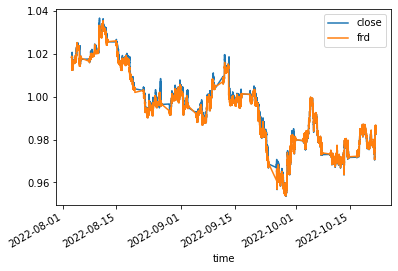

In [8]:
bars[['close', 'frd']].plot()

<AxesSubplot:xlabel='time'>

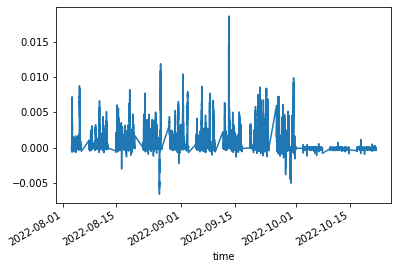

In [9]:
(bars['close'] - bars['frd']).plot()

### Strangle anomolies that can differ by a whole cent!

# Now try Twelvedata (third party data provider)

In [11]:
import requests
import io

response = requests.get("https://api.twelvedata.com/time_series?apikey=b1380736fa4d496881c9a1fc87d3dcb3&interval=1min&symbol=EUR/USD&outputsize=4320&start_date=2022-10-01 00:20:00&end_date=2022-10-21 00:20:00&format=CSV")
df = pd.read_csv(io.StringIO(response.text), sep=";")

In [12]:
fx = pd.read_csv('data/EURUSD_1min.txt', names = ['day', 'time', 'open', 'high', 'low', 'close', 'volume'])
fx['datetime'] = fx['day'].astype(str) + " " + fx['time']
fx['datetime'] = pd.to_datetime(fx['datetime'], infer_datetime_format = True)

fx = fx.drop(columns = ['day', 'time'])
# fx = fx[fx['datetime'].isin(bars.index)]
fx = fx.set_index('datetime')

In [13]:
df['datetime'] = pd.to_datetime(df['datetime'], infer_datetime_format = True) - timedelta(hours = 11)

In [14]:
df = df[df['datetime'].isin(fx.index)]
fx = fx[fx.index.isin(df['datetime'])]

In [15]:
df = df.set_index('datetime')

In [16]:
df['frd'] = fx['close']

<AxesSubplot:xlabel='datetime'>

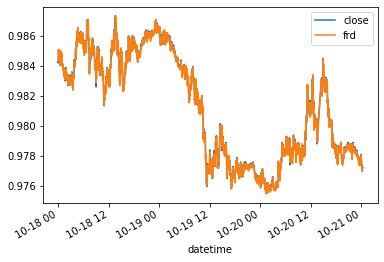

In [17]:
df[['close', 'frd']].plot()

<AxesSubplot:xlabel='datetime'>

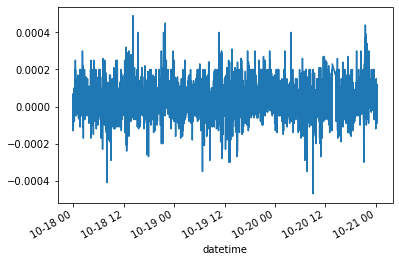

In [18]:
(df['close'] - df['frd']).plot()

## Still not perfect but seemingly within reason and can always be finetuned